## Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# For training set
house_price_path = '/kaggle/input/house-prices-advanced-regression-techniques/train.csv'
house_price = pd.read_csv(house_price_path, index_col='Id')

# For test set
house_price_test_path = '/kaggle/input/house-prices-advanced-regression-techniques/test.csv'
house_price_test = pd.read_csv(house_price_test_path, index_col='Id')

In [3]:
house_price

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


In [4]:
house_price_test

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml


So from code above, we found the target is a regression problem for this challenge.

In [5]:
train_raw = house_price.drop(columns=['SalePrice']).copy()
train_raw

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal


In [6]:
test_raw = house_price_test.copy()
test_raw

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml


## Pre-Processing Data

In [7]:
# Check feature data type
train_raw.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

We could see data type is mixing of various types, we will encoding later after we handle missing data.

In [8]:
missing_val_column = train_raw.isnull().sum()
missing_columns = missing_val_column[missing_val_column > 0]
missing_columns

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

> All function to analyze and hanling a missing data

In [9]:
from scipy import stats
from sklearn.impute import SimpleImputer

In [10]:
def analyze_missing_values(train_df, test_df=None):
    """
    Analyze missing values and provide insights for handling them.
    
    Parameters:
    train_df (pandas.DataFrame): Training dataset
    test_df (pandas.DataFrame, optional): Test dataset
    
    Returns:
    dict: Analysis results and recommendations
    """
    analysis = {}
    
    # Analyze missing values in training set
    missing_columns_train = train_df.isnull().sum()
    
    # Filter for columns with missing values in training set
    missing_columns_train = missing_columns_train[missing_columns_train > 0]
    
    # Calculate missing value statistics for training set
    missing_stats = pd.DataFrame({
        'missing_count': missing_columns_train,
        'missing_percentage': (missing_columns_train / len(train_df) * 100).round(2)
    }).sort_values('missing_percentage', ascending=False)
    
    # Identify columns by missing percentage in training set only
    high_missing = missing_stats[missing_stats['missing_percentage'] > 40].index.tolist()
    medium_missing = missing_stats[(missing_stats['missing_percentage'] > 20) & 
                                 (missing_stats['missing_percentage'] <= 40)].index.tolist()
    low_missing = missing_stats[(missing_stats['missing_percentage'] > 0) & 
                               (missing_stats['missing_percentage'] <= 20)].index.tolist()
    
    # If test set is provided, identify columns present in test but not in train set
    columns_in_test_set_only = []
    if test_df is not None:
        columns_in_test_set_only = [col for col in test_df.columns if col not in train_df.columns]
        if only_columns_in_test_set:
            print(f"Warning: Following columns found in test set but not in training set: {columns_in_test_set_only}")
    
    # Analyze distribution for numeric columns in training set
    numeric_cols = train_df.select_dtypes(include=[np.number]).columns
    skewness = {}
    filling_recommendations = {}
    for col in numeric_cols:
        if col in low_missing or col in medium_missing:
            # Calculate skewness of non-missing values
            skew = stats.skew(train_df[col].dropna())
            skewness[col] = skew
            
            # Recommend filling method based on skewness
            if abs(skew) > 1:  # Highly skewed
                filling_recommendations[col] = 'median'
            else:
                filling_recommendations[col] = 'mean'
    
    # Analyze categorical columns in training set
    categorical_cols = train_df.select_dtypes(include=['object']).columns
    categorical_recommendations = {}
    for col in categorical_cols:
        if col in low_missing or col in medium_missing:
            # Check if mode is dominant (>50% frequency)
            mode_freq = train_df[col].value_counts(normalize=True).iloc[0]
            if mode_freq > 0.5:
                categorical_recommendations[col] = 'mode'
            else:
                categorical_recommendations[col] = 'Not_Specified'
    
    # Compile the results
    analysis['missing_stats'] = missing_stats
    analysis['recommendations'] = {
        'drop_columns': high_missing,
        'numeric_filling': filling_recommendations,
        'categorical_filling': categorical_recommendations,
        'columns_in_test_set_only': columns_in_test_set_only  
    }
    
    return analysis

In <code>analyze_missing_values()</code>, We need to analyze a strategy to determine the optimal strategy for data characterization for handling missing data.

In [12]:
def handling_missing_data(df, missing_analysis, df_test=None):
    """
    Handles missing data based on recommendations from an analysis of missing values. 
    If only a training set is provided, it will handle missing data in that set alone. 
    If both training and test sets are provided, strategies are calculated
    from the training set and then applied to the test set without modifying the training set. 
    
    Parameters:
    df (pandas.DataFrame): Input training dataset to fit imputer values from
    missing_analysis (dict): Analysis of missing values with recommendations
    df_test (pandas.DataFrame, optional): Input testing dataset to transform only
    
    Returns:
    df_test (pandas.DataFrame) if df_test provided: Test dataset with handled missing values
    df (pandas.DataFrame) if df_test not provided: Training dataset with handled missing values
    """
    
    # Create copies to avoid modifying original data
    df = df.copy()
    if df_test is not None:
        df_test = df_test.copy()
    
    # Drop specified columns
    print("========== Drop columns ==========")
    drop_columns = missing_analysis['recommendations']['drop_columns']
    print(f"Before dropping columns: {len(df.columns)}")
    if df_test is not None:
        # For test set: drop both high-missing columns and test-only columns
        columns_in_test_set_only = missing_analysis['recommendations'].get('columns_in_test_set_only', [])
        columns_to_drop = list(set(drop_columns + columns_in_test_set_only))
        df_test = df_test.drop(columns=columns_to_drop)
    else:
        # For training set: only drop high-missing columns
        df = df.drop(columns=drop_columns)
    print(f"After dropping columns: {len(df.columns)}")
        
    # Handle numerical columns
    print("========== Numerical columns handling ==========")
    numeric_strategies = missing_analysis['recommendations']['numeric_filling']
    for column, strategy in numeric_strategies.items():
        if column in df.columns:
            imputer = SimpleImputer(missing_values=np.nan, strategy=strategy)
            if df_test is not None and column in df_test.columns:
                # For test set: First fit on training data, then transform test data only
                print(f"Before {column} handling >> Test na/null: {df_test[column].isna().sum()}, dtype: {df_test[column].dtypes}")
                imputer.fit(df[[column]])  # Fit on training data
                df_test[[column]] = imputer.transform(df_test[[column]])  # Transform test only
                fill_value = imputer.statistics_[0]
                print(f"After {column} handling - strategy '{strategy}' >> Test na/null: {df_test[column].isna().sum()}, "
                      f"{strategy}:{fill_value}, dtype: {df_test[column].dtypes}")
            else:
                # For training set: Fit and transform training data
                print(f"Before {column} handling >> Train na/null: {df[column].isna().sum()}, dtype: {df[column].dtypes}")
                df[[column]] = imputer.fit_transform(df[[column]])
                fill_value = imputer.statistics_[0]
                print(f"After {column} handling - strategy '{strategy}' >> Train na/null: {df[column].isna().sum()}, "
                      f"{strategy}:{fill_value}, dtype: {df[column].dtypes}")
    
    # Handle categorical columns
    print("========== Categorical columns handling ==========")
    categorical_strategies = missing_analysis['recommendations']['categorical_filling']
    for column, strategy in categorical_strategies.items():
        if column in df.columns:
            if df_test is not None and column in df_test.columns:
                print(f"Before {column} handling >> Test na/null: {df_test[column].isna().sum()}, dtype: {df_test[column].dtypes}")
            else:
                print(f"Before {column} handling >> Train na/null: {df[column].isna().sum()}, dtype: {df[column].dtypes}")
            if strategy == 'mode':
                mode_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
                if df_test is not None and column in df_test.columns:
                    # For test set: First fit on training data, then transform test data only
                    mode_imputer.fit(df[[column]])  # Fit on training data
                    df_test[[column]] = mode_imputer.transform(df_test[[column]])  # Transform test only
                    fill_value = mode_imputer.statistics_[0]
                    print(f"After {column} handling - strategy '{strategy}' >> Test na/null: {df_test[column].isna().sum()}, "
                          f"{strategy}:{fill_value}, dtype: {df_test[column].dtypes}")
                else:
                    # For training set: Fit and transform training data
                    df[[column]] = mode_imputer.fit_transform(df[[column]])
                    fill_value = mode_imputer.statistics_[0]
                    print(f"After {column} handling - strategy '{strategy}' >> Train na/null: {df[column].isna().sum()}, "
                          f"{strategy}:{fill_value}, dtype: {df[column].dtypes}")
            else:
                # Fill with specified value
                fill_value = strategy
                if df_test is not None and column in df_test.columns:
                    df_test[column] = df_test[column].fillna(strategy)
                    print(f"After {column} handling - strategy 'fill {strategy}' >> Test na/null: {df_test[column].isna().sum()}, "
                          f"fill:{fill_value}, dtype: {df_test[column].dtypes}")
                else:
                    df[column] = df[column].fillna(strategy)
                    print(f"After {column} handling - strategy 'fill {strategy}' >> Train na/null: {df[column].isna().sum()}, "
                          f"fill:{fill_value}, dtype: {df[column].dtypes}")
                
    return df_test if df_test is not None else df

So, we will <code>handling_missing_data</code> to handling a missing data following analyzing strategey from <code>analyze_missing_values()</code>.

In [13]:
def before_and_after_handling(data, data_processced):
    # Set a random seed for reproducibility
    random_state = 0
    np.random.seed(random_state)
    
    # Randomly select columns to check
    numerical_cols = data.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
    
    # Randomly sample columns for checking
    random_numerical_col = np.random.choice(numerical_cols, size=1)[0]
    random_categorical_col = np.random.choice(categorical_cols, size=1)[0]
    
    print("========== Before handling missing data =========")
    print(f"All missing values in dataset: {data.isna().sum().sum()}")
    print(f"All columns in dataset: {len(data.columns)}")
    print(f"Random check numerical column unique values:\n",
          data[random_numerical_col].unique())
    print(f"Random check categorical column unique values:\n",
          data[random_categorical_col].unique())
    
    print("========== After handling missing data =========")
    print(f"All missing values in dataset: {data_processced.isna().sum().sum()}")
    print(f"All columns in dataset: {len(data_processced.columns)}")
    print(f"Random check numerical column unique values:\n",
          data_processced[random_numerical_col].unique())
    print(f"Random check categorical column unique values:\n",
          data_processced[random_categorical_col].unique())

Then, compare for recheck with <code>before_and_after_handling</code>

> Using defind function to analyze and handling a missing data

In [14]:
train_raw_analysis = analyze_missing_values(train_raw)
train_raw_analysis

{'missing_stats':               missing_count  missing_percentage
 PoolQC                 1453               99.52
 MiscFeature            1406               96.30
 Alley                  1369               93.77
 Fence                  1179               80.75
 MasVnrType              872               59.73
 FireplaceQu             690               47.26
 LotFrontage             259               17.74
 GarageType               81                5.55
 GarageYrBlt              81                5.55
 GarageFinish             81                5.55
 GarageQual               81                5.55
 GarageCond               81                5.55
 BsmtFinType2             38                2.60
 BsmtExposure             38                2.60
 BsmtFinType1             37                2.53
 BsmtCond                 37                2.53
 BsmtQual                 37                2.53
 MasVnrArea                8                0.55
 Electrical                1                0.07,
 '

Next, we will proceed to handling missing data.

In [16]:
train_missing_processed = handling_missing_data(train_raw, train_raw_analysis)

========== Drop columns ==========
Before dropping columns: 79
After dropping columns: 73
========== Numerical columns handling ==========
Before LotFrontage handling >> Train na/null: 259, dtype: float64
After LotFrontage handling - strategy 'median' >> Train na/null: 0, median:69.0, dtype: float64
Before MasVnrArea handling >> Train na/null: 8, dtype: float64
After MasVnrArea handling - strategy 'median' >> Train na/null: 0, median:0.0, dtype: float64
Before GarageYrBlt handling >> Train na/null: 81, dtype: float64
After GarageYrBlt handling - strategy 'mean' >> Train na/null: 0, mean:1978.5061638868744, dtype: float64
========== Categorical columns handling ==========
Before BsmtQual handling >> Train na/null: 37, dtype: object
After BsmtQual handling - strategy 'fill Not_Specified' >> Train na/null: 0, fill:Not_Specified, dtype: object
Before BsmtCond handling >> Train na/null: 37, dtype: object
After BsmtCond handling - strategy 'mode' >> Train na/null: 0, mode:TA, dtype: object
B

In [17]:
before_and_after_handling(train_raw, train_missing_processed)

========== Before handling missing data =========
All missing values in dataset: 7829
All columns in dataset: 79
Random check numerical column unique values:
 [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
Random check categorical column unique values:
 ['Reg' 'IR1' 'IR2' 'IR3']
========== After handling missing data =========
All missing values in dataset: 0
All columns in dataset: 73
Random check numerical column unique values:
 [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
Random check categorical column unique values:
 ['Reg' 'IR1' 'IR2' 'IR3']


So, we can see a number of missing values is zero, and 'nan' in the unique value has disappeared after we are handling a missing data.

For test set we should keep fill a missing value same strategies of train set for prevent bias and leaking information. And drop feature in test set that not in train set for provide same model feature dimesion.

In [18]:
test_raw_analysis = analyze_missing_values(test_raw)

In [19]:
test_missing_processed = handling_missing_data(train_raw, test_raw_analysis, test_raw)

========== Drop columns ==========
Before dropping columns: 79
After dropping columns: 79
========== Numerical columns handling ==========
Before LotFrontage handling >> Test na/null: 227, dtype: float64
After LotFrontage handling - strategy 'mean' >> Test na/null: 0, mean:70.04995836802665, dtype: float64
Before MasVnrArea handling >> Test na/null: 15, dtype: float64
After MasVnrArea handling - strategy 'median' >> Test na/null: 0, median:0.0, dtype: float64
Before BsmtFinSF1 handling >> Test na/null: 1, dtype: float64
After BsmtFinSF1 handling - strategy 'median' >> Test na/null: 0, median:383.5, dtype: float64
Before BsmtFinSF2 handling >> Test na/null: 1, dtype: float64
After BsmtFinSF2 handling - strategy 'median' >> Test na/null: 0, median:0.0, dtype: float64
Before BsmtUnfSF handling >> Test na/null: 1, dtype: float64
After BsmtUnfSF handling - strategy 'mean' >> Test na/null: 0, mean:567.2404109589041, dtype: float64
Before TotalBsmtSF handling >> Test na/null: 1, dtype: float6

In [20]:
test_missing_processed.isna().sum().sum()

0

In [21]:
missing_val_column = test_missing_processed.isnull().sum()
missing_columns = missing_val_column[missing_val_column > 0]
missing_columns

Series([], dtype: int64)

Then even though we use the same strategies of training set (data) but in test set (ddata_test) some columns are containing a missing value that is different from training set. So let's check what columns are containing a missing value of the test set.

> Encoding

We need to encoding a cetegycal data or string data to numerical value before input to a model for training.

In [22]:
from sklearn.preprocessing import LabelEncoder

In [23]:
class DataEncoder:
    def __init__(self, threshold=10):
        self.threshold = threshold
        self.label_encoders = {}
        self.encoding_types = {}
        self.unique_values = {}
    
    def fit(self, data, string_col_list):
        """Fit encoders on training data only"""
        for col in string_col_list:
            unique_vals = data[col].unique()
            length = len(unique_vals)
            self.unique_values[col] = unique_vals
            
            if length == 2 or length > self.threshold:
                # Label encoding
                self.encoding_types[col] = 'label'
                self.label_encoders[col] = LabelEncoder()
                self.label_encoders[col].fit(data[col])
            else:
                # One-hot encoding
                self.encoding_types[col] = 'onehot'
    
    def transform(self, data, string_col_list):
        """Transform data using fitted encoders"""
        data_encoded = data.copy()
        
        for col in string_col_list:
            if col not in self.encoding_types:
                raise ValueError(f"Column {col} was not present during fit")
                
            if self.encoding_types[col] == 'label':
                # Handle unseen categories for label encoding
                unique_new = set(data_encoded[col].unique())
                unique_train = set(self.unique_values[col])
                unseen_categories = unique_new - unique_train
                
                if unseen_categories:
                    print(f"Warning: Unseen categories in column {col}: {unseen_categories}")
                    # Replace unseen categories with the most frequent category from training
                    most_frequent = pd.Series(self.unique_values[col]).mode()[0]
                    data_encoded[col] = data_encoded[col].replace(list(unseen_categories), most_frequent)
                
                data_encoded[col] = self.label_encoders[col].transform(data_encoded[col])
            else:
                # One-hot encoding
                # Only create columns that were present in training
                dummies = pd.get_dummies(data_encoded[col], prefix=col)
                missing_cols = set(pd.get_dummies(self.unique_values[col], prefix=col).columns) - set(dummies.columns)
                
                # Add missing columns with 0s
                for missing_col in missing_cols:
                    dummies[missing_col] = 0
                    
                # Remove columns not present in training
                extra_cols = set(dummies.columns) - set(pd.get_dummies(self.unique_values[col], prefix=col).columns)
                dummies = dummies.drop(columns=extra_cols)
                
                # Ensure columns are in the same order as during training
                dummies = dummies[sorted(dummies.columns)]
                
                # Replace original column with dummy columns
                data_encoded = data_encoded.drop(columns=[col])
                data_encoded = pd.concat([data_encoded, dummies], axis=1)
        
        return data_encoded

From class <code> DataEncoder</code> will contain seperate method for ensure to fit encoders on training data only. Becuase, we need the same encoding strategy for both of train and test set.

In [24]:
train_missing_processed.shape

(1460, 73)

In [25]:
test_missing_processed.shape

(1459, 73)

In [26]:
# Match a column dtype = object
string_cols = list(np.where((train_missing_processed.dtypes == object))[0])   #return index columns of string column
string_cols_names = train_missing_processed.columns[string_cols]

In [27]:
encoder = DataEncoder(threshold=10)
encoder.fit(train_missing_processed, string_cols_names)

In [28]:
train_encoded = encoder.transform(train_missing_processed, string_cols_names)
train_encoded.shape

(1460, 213)

In [29]:
test_encoded = encoder.transform(test_missing_processed, string_cols_names)
test_encoded.shape

(1459, 213)

In [30]:
print(set(train_encoded.columns) - set(test_encoded.columns))  # Columns in train but not in test
print(set(test_encoded.columns) - set(train_encoded.columns))  # Columns in test but not in train

set()
set()


So, this can confirm the column names of the train and test sets are the same all names from encoded.

## Feature Selection

We need to select with many methods and then merge them together to make sure we removed high multicolinearity (high correlation) and low variance.

In [32]:
from sklearn.feature_selection import mutual_info_regression, VarianceThreshold, RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor

In [33]:
class FeatureSelector:
    
    def __init__(self, X, y, n_features=10):
        self.X = X
        self.y = y
        self.n_features = n_features
        self.feature_scores = {}
    
    def random_forest_importance(self, importance_threshold=0.01):
        """Random Forest with importance threshold and n_features limit"""
        rf = RandomForestRegressor(n_estimators=100, 
                                 random_state=42,
                                 min_impurity_decrease=0.01)
        rf.fit(self.X, self.y)
        rf_importances = pd.Series(rf.feature_importances_, index=self.X.columns)
        important_features = rf_importances[rf_importances >= importance_threshold]
        important_features = important_features.nlargest(self.n_features)
        self.feature_scores['random_forest'] = important_features
        return important_features
    
    def xgboost_importance(self, importance_threshold=0.01):
        """
        Use XGBoost model to calculate feature importance.
        """
        model = XGBRegressor()
        model.fit(self.X, self.y)
        importances = model.feature_importances_
        xgb_importances = pd.Series(importances, index=self.X.columns)
        selected_xgb = xgb_importances[xgb_importances >= importance_threshold]
        selected_xgb = selected_xgb.nlargest(self.n_features)
        self.feature_scores['xgboost'] = selected_xgb
        return selected_xgb
    
    def lasso_selection(self, alpha=1.0):
        """Feature selection using Lasso (L1 regularization)."""
        lasso = LassoCV(cv=5).fit(self.X, self.y)
        lasso_importances = pd.Series(np.abs(lasso.coef_), index=self.X.columns)
        lasso_importances = lasso_importances[lasso_importances > 0].nlargest(self.n_features)
        self.feature_scores['lasso'] = lasso_importances
        return lasso_importances   

    def correlation_matrix(self, lower_threshold=0.5, upper_threshold=0.7):
        """
        Calculates and returns the correlation matrix of the features, filtered by lower and upper thresholds.
        """
        correlation_matrix = self.X.corr(method='spearman').abs()
        filtered_matrix = correlation_matrix[(correlation_matrix >= lower_threshold) & 
                                             (correlation_matrix <= upper_threshold)]
        selected_correlations = filtered_matrix.max().nlargest(self.n_features)
        top_features_matrix = filtered_matrix.loc[selected_correlations.index, selected_correlations.index]
        self.feature_scores['correlation_matrix'] = top_features_matrix
        return top_features_matrix

    def combine_feature(self):
        """Combine features by taking the union of all selected features from each method."""
        # Gather all selected features
        all_features = set()
        for method, scores in self.feature_scores.items():
            all_features.update(scores.index)

        # If more features than desired, keep only the top n_features based on the frequency of selection
        if len(all_features) > self.n_features:
            # Count occurrences of each feature across different methods
            feature_counts = pd.Series(list(all_features)).value_counts()
            # Select top n_features based on frequency across methods
            top_features = feature_counts.nlargest(self.n_features).index
        else:
            top_features = all_features

        return list(top_features)

We can rough estimate the optimal feature selection, for example, in the example above that uses <code>RandomForestRegressor</code> to visualize the relationship between feature rank and feature importance score. The graph stratifies from highest rank on the left side to lowest rank on the right side.

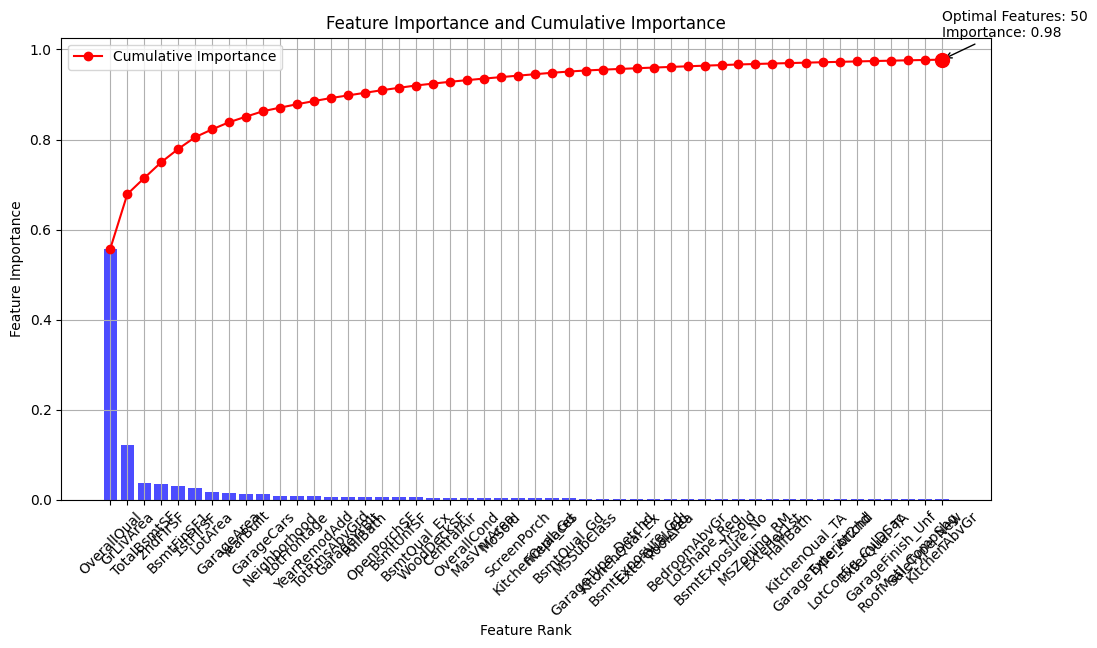

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Sample Data
# Replace this with your actual data
X = train_encoded
y = house_price['SalePrice']

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort feature importances in descending order

# Number of features to plot
n_features = 50
selected_indices = indices[:n_features]
selected_importances = importances[selected_indices]

# Cumulative feature importance
cumulative_importances = np.cumsum(selected_importances)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.bar(range(n_features), selected_importances, align='center', alpha=0.7, color='b')
plt.plot(range(n_features), cumulative_importances, marker='o', color='red', label='Cumulative Importance')

# Adding markers for specific points
optimal_feature_count = np.argmax(cumulative_importances) + 1  # Get the number of features for maximum importance
optimal_importance = cumulative_importances[optimal_feature_count - 1]

plt.scatter(optimal_feature_count - 1, optimal_importance, color='red', s=100, zorder=5)
plt.annotate(f'Optimal Features: {optimal_feature_count}\nImportance: {optimal_importance:.2f}',
             xy=(optimal_feature_count - 1, optimal_importance), 
             xytext=(optimal_feature_count - 1, optimal_importance + 0.05),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

# Axis labels and title
plt.xlabel('Feature Rank')
plt.ylabel('Feature Importance')
plt.title('Feature Importance and Cumulative Importance')
plt.xticks(range(n_features), X.columns[selected_indices], rotation=45)
plt.legend()
plt.grid(True)
plt.axhline(0, color='black', lw=0.5, linestyle='--')  # Horizontal line at y=0
plt.show()

In [35]:
# Selected from selector selection
selector = FeatureSelector(train_encoded, house_price['SalePrice'], n_features=50)

# Accuracy comment after selector is based on R2 score all feature in train_encoded
rf_features = selector.random_forest_importance() 
xg_feature = selector.xgboost_importance() 
lasso_features = selector.lasso_selection() 
unsupervise_correlation = selector.correlation_matrix() 

# Combine all feature 
combined_features = selector.combine_feature()
print("Top features after combining scores:", combined_features)

Top features after combining scores: ['GrLivArea', 'GarageCond_Po', 'SaleType_WD', 'HeatingQC_TA', 'GarageFinish_Unf', 'Condition2_Feedr', 'Foundation_PConc', 'LandContour_Lvl', 'BsmtFinType1_Unf', 'TotalBsmtSF', 'SaleCondition_Partial', 'KitchenAbvGr', 'HalfBath', 'SaleCondition_Normal', 'BsmtCond_Fa', 'LotArea', 'Fireplaces', 'OverallQual', 'LandContour_Bnk', 'KitchenQual_Gd', 'GarageArea', 'YearBuilt', 'MasVnrArea', 'GarageQual_Po', 'GarageType_Detchd', 'Condition1_Feedr', 'SaleCondition_Abnorml', 'BsmtUnfSF', 'ExterQual_TA', '2ndFlrSF', 'BsmtFinSF1', 'RoofMatl_Tar&Grv', 'BldgType_TwnhsE', 'WoodDeckSF', 'KitchenQual_TA', 'MiscVal', 'GarageYrBlt', 'RoofMatl_CompShg', 'BsmtCond_TA', 'BsmtQual_TA', 'BldgType_1Fam', 'Condition2_Norm', 'FullBath', 'Condition1_Norm', 'HouseStyle_1Story', 'MSSubClass', 'ExterQual_Gd', 'GarageCars', 'SaleType_New', 'BsmtExposure_No']


In [36]:
X = train_encoded[combined_features].copy()
y = house_price['SalePrice'].copy()
X_test = test_encoded[combined_features].copy()

## Generalize the data (Train test Split)

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2, random_state=0)

## Model and Evaluation

> XGBoost Model

$\;\;\;\;$ This model will using XGBoost with GridSearchCV for optimze hyper parameter tuninng for chosen optimal performance. Becareful if acuuracy is very high or mean squre error to low, may be due to overfitting when using to prediction a new data from the future unseen data.

$\;\;\;\;$ And The number of hyperparameters you select depends on your experience with the data and model. In this post, we explore tuning various hyperparameters through trial and error to tackle this challenge. As the number of hyperparameters increases, the training time grows exponentially due to the use of grid search with cross-validation technique to find the optimal values.

In [38]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Creating the pipeline
pipeline_xgb = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('xgb', XGBRegressor(objective='reg:squarederror'))  # XGBoost model
])

# Define the parameter grid for GridSearchCV
param_grid_xgb = {                 
    'xgb__n_estimators': [100, 200],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__max_depth': [10, 20, 30],
    'xgb__min_child_weight': [1, 3, 5],
    'xgb__reg_alpha': [0, 0.1, 1], 
}

# Perform GridSearchCV
grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=5, scoring='neg_mean_squared_error')
grid_search_xgb.fit(X_train, y_train)

# Best parameters and score
print("Best XGBoost Parameters:", grid_search_xgb.best_params_)
print("Best XGBoost RMSE:", np.sqrt(-grid_search_xgb.best_score_))

# Evaluate on validation set
best_xgb_model = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_validate)

# Calculate evaluation metrics
rmse_xgb = np.sqrt(mean_squared_error(y_validate, y_pred_xgb))
mae_xgb = mean_absolute_error(y_validate, y_pred_xgb)
r2_xgb = r2_score(y_validate, y_pred_xgb)

# Print evaluation results
print(f"XGBoost Model RMSE on Validation Set: {rmse_xgb:.2f}")
print(f"R² score: {r2_xgb:.2f}")
print(f"Mean Absolute Error: {mae_xgb:.2f}")

Best XGBoost Parameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 10, 'xgb__min_child_weight': 5, 'xgb__n_estimators': 100, 'xgb__reg_alpha': 0.1}
Best XGBoost RMSE: 30892.871120427815
XGBoost Model RMSE on Validation Set: 30843.71
R² score: 0.86
Mean Absolute Error: 18646.94


Then we can predict X_test from the test set for model evaluation on the last step of model training.

In [39]:
# Predict the SalePrice for the test set
y_pred_test = best_xgb_model.predict(X_test)

# Create a DataFrame for the output
output = pd.DataFrame({
    'Id': X_test.index,  # Make sure X_test has an index that corresponds to IDs
    'SalePrice': y_pred_test
})

# Save the predictions to a CSV file
output.to_csv('submission.csv', index=False)

print("Predictions saved to 'submission.csv'")

Predictions saved to 'submission.csv'
